In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
import missingno as msno

plt.rcParams['font.family'] = 'AppleGothic'

# 2. 전처리
## 2-1. 결측치 처리
- 0이나 특정 상수로 대치, 대푯값, 단순확률대치법, 다른 변수들로부터 모델링햐여 결측값 예측, 결측값 여부를 새로운 특징으로 추출, 보간법(시계열)
- 데이터 양에 비해 결측치가 극소수이거나, 절대다수인 경우 결측치가 있는 행이나 열 자체를 삭제하기도 함

### 결측치 확인

In [2]:
wine = pd.read_csv("https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/2-1_wine.csv",
                  index_col=0).filter(['Alcohol', 'Malicacid', 'Ash', 'Magnesium', 'Hue'])

print(wine.isna().sum())

Alcohol      0
Malicacid    0
Ash          0
Magnesium    0
Hue          0
dtype: int64


In [3]:
# 임의 결측치 데이터 생성
from numpy.random import randint
wine_m = wine.copy()
for col in ['Alcohol', 'Ash']:
    random_idx = randint(0, len(wine), 25)
    wine_m.loc[random_idx, col] = np.nan
print(wine_m.isna().sum())

Alcohol      25
Malicacid     0
Ash          24
Magnesium     0
Hue           0
dtype: int64


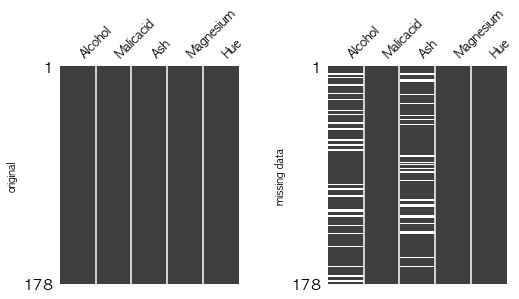

In [4]:
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['font.family'] = "AppleGothic"
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

fig, ax = plt.subplots(1,2, figsize=(8,4))
plt.subplots_adjust(wspace=0.5)

msno.matrix(df=wine, figsize=(5,5), fontsize=12, ax=ax[0], sparkline=False)
ax[0].set_ylabel("original");

msno.matrix(df=wine_m, figsize=(5,5), fontsize=12, ax=ax[1], sparkline=False)
ax[1].set_ylabel("missing data");

plt.show()

### Zero imputation & Constant imputation

In [5]:
wine_m[['Alcohol', 'Ash']].head(10)

,Alcohol,Ash
0,14.23,2.43
1,13.20,2.14
2,13.16,2.67
3,14.37,2.50
4,13.24,2.87
5,14.20,2.45
6,NaN,NaN
7,14.06,2.61
8,14.83,2.17
9,NaN,2.27


In [6]:
wine_imp = wine_m.fillna(0)
wine_imp[['Alcohol', 'Ash']].head(10)

,Alcohol,Ash
0,14.23,2.43
1,13.20,2.14
2,13.16,2.67
3,14.37,2.50
4,13.24,2.87
5,14.20,2.45
6,0.00,0.00
7,14.06,2.61
8,14.83,2.17
9,0.00,2.27


### 대푯값으로 채우는 방법
- 해당 변수의 결측되지 않은 다른 값들로 구한 평균값, 중앙값, 최빈값 등의 대푯값으로 결측치 대치
- 로그 변환 등을 통해 치우침이 적은 분포로 데이터 변환 후, 대푯값 구해 대치

In [7]:
wine_m[['Alcohol', 'Ash']].head(10)

,Alcohol,Ash
0,14.23,2.43
1,13.20,2.14
2,13.16,2.67
3,14.37,2.50
4,13.24,2.87
5,14.20,2.45
6,NaN,NaN
7,14.06,2.61
8,14.83,2.17
9,NaN,2.27


In [8]:
# 결측치를 대표값 'mean'으로 대치
from sklearn.impute import SimpleImputer

# strategy = 'mean', 'median', or 'most_frequent'
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
wine_imp1 = imputer.fit_transform(wine_m)
wine_imp1 = pd.DataFrame(wine_imp1, columns=wine_m.columns)

al_mean = wine_m['Alcohol'].mean()
as_mean = wine_m['Ash'].mean()

print(f'alcohol mean: {al_mean:.2f}, ash mean: {as_mean:.2f}')
print(wine_imp1[['Alcohol', 'Ash']].head(10).round(2))

alcohol mean: 13.00, ash mean: 2.37
   Alcohol   Ash
0    14.23  2.43
1    13.20  2.14
2    13.16  2.67
3    14.37  2.50
4    13.24  2.87
5    14.20  2.45
6    13.00  2.37
7    14.06  2.61
8    14.83  2.17
9    13.00  2.27


### 단순확률대치법
- 유사한 데이터셋에서 랜덤하게 샘플링한 값으로 대치
    - Hot-deck : 현재 진행중인 연구에서 비슷한 성향 데이터 중 랜덤 선택
    - Cold-deck : 외부 출처 혹은 비슷한 연구에서 대체할 데이터 가져오는 것

In [9]:
# Hot-Deck
# wine이 wine_m과 비슷한 성향이라고 가정하고 wine에서 랜덤하게 선택하여 wine_m 대치
wine_imp2 = wine_m.copy()

for feature in ['Alcohol', 'Ash']:
    missing_idx = wine_imp2.loc[wine_imp2[feature].isna()==True].index
    wine_imp2.loc[missing_idx, feature] = wine[feature].sample(len(missing_idx)).values

wine_imp2.isna().sum()

Alcohol      0
Malicacid    0
Ash          0
Magnesium    0
Hue          0
dtype: int64

In [10]:
wine_imp2.head()

,Alcohol,Malicacid,Ash,Magnesium,Hue
0,14.23,1.71,2.43,127,1.04
1,13.20,1.78,2.14,100,1.05
2,13.16,2.36,2.67,101,1.03
3,14.37,1.95,2.50,113,0.86
4,13.24,2.59,2.87,118,1.04


### 다른 변수들로 모델링하여 결측값 예측
- KNN imputer : 정확할 때가 많지만, 전체 데이터셋을 올려야해서 메모리가 많이 필요하고 이상치에 민감, 
- 기타 회귀 및 분류 알고리즘 이용 가능

In [11]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
wine_imp3 = imputer.fit_transform(wine_m)
wine_imp3 = pd.DataFrame(wine_imp3, columns=wine_m.columns)
wine_imp3.isna().sum()

Alcohol      0
Malicacid    0
Ash          0
Magnesium    0
Hue          0
dtype: int64

### 보간법
- 시계열 데이터 결측치 대치 : linear, polynomial, spline
- 맨 앞의 결측치는 보간되지 않으므로 단순하게 다음값으로 채움

In [12]:
wine_imp4 = wine_m.interpolate(method='linear')
wine_imp4.isna().sum()

Alcohol      0
Malicacid    0
Ash          0
Magnesium    0
Hue          0
dtype: int64

### 실제값과 대치값 비교

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

feature = 'Alcohol'
report = pd.DataFrame({'실제값':wine[feature], "mean대치":wine_imp1[feature],
                      'Hotdeck':wine_imp2[feature], 'KNN':wine_imp3[feature],
                      'linear interpolate':wine_imp4[feature]})

score_report = pd.DataFrame(index=['MAE', 'MSE'])
for col in report.columns:
    mae = mean_absolute_error(report['실제값'], report[col])
    mse = mean_squared_error(report['실제값'], report[col])
    score_report.loc['MAE', col] = mae
    score_report.loc['MSE', col] = mse

score_report.round(3)

,실제값,mean대치,Hotdeck,KNN,linear interpolate
MAE,0.0,0.089,0.117,0.111,0.062
MSE,0.0,0.077,0.145,0.117,0.038


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

feature = 'Ash'
report = pd.DataFrame({'실제값':wine[feature], "mean대치":wine_imp1[feature],
                      'Hotdeck':wine_imp2[feature], 'KNN':wine_imp3[feature],
                      'linear interpolate':wine_imp4[feature]})

score_report = pd.DataFrame(index=['MAE', 'MSE'])
for col in report.columns:
    mae = mean_absolute_error(report['실제값'], report[col])
    mse = mean_squared_error(report['실제값'], report[col])
    score_report.loc['MAE', col] = mae
    score_report.loc['MSE', col] = mse

score_report.round(3)

,실제값,mean대치,Hotdeck,KNN,linear interpolate
MAE,0.0,0.022,0.036,0.028,0.027
MSE,0.0,0.006,0.019,0.009,0.010


## 2-2. 이상치 처리
- 이상치 데이터 판정기준

1) ESD : mean-3\*std < data < mean+3\*std 

2) 기하평균 - 2.5 \* std < data < 기하평균 + 2.5 \* std

3) Q1 - 1.5\* IQR < data < Q3 + 1.5\* IQR

4) DBSCAN 통해 -1로 분류되는 값

- 이상치 처리방법 : 절단, 조정, 클리핑

In [15]:
wine = pd.read_csv("https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/2-1_wine.csv",
                  index_col=0).filter(['Alcohol', 'Malicacid', 'Ash', 'Magnesium', 'Hue'])

IQR = wine['Malicacid'].quantile(0.75) - wine['Malicacid'].quantile(0.25)
top = wine['Malicacid'].quantile(0.75) + IQR * 1.5
down = wine['Malicacid'].quantile(0.25) - IQR * 1.5

out_id = wine.loc[(wine['Malicacid']>=top) | (wine['Malicacid']<=down)].index
print("이상치 index", out_id)

이상치 index Int64Index([123, 137, 173], dtype='int64')


### 절단
- 절단 후 새로운 이상치 생길 수 있으나 이는 분석가가 상황에 맞게 설정 필요

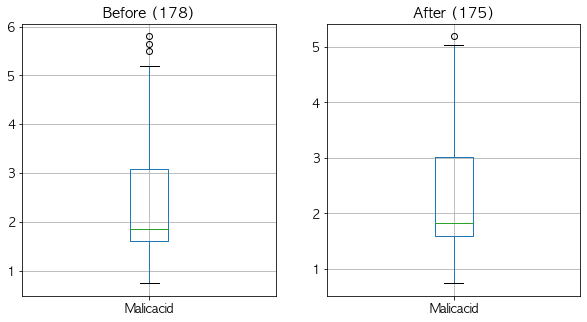

In [16]:
prep_df = wine[['Malicacid']].drop(out_id, axis=0)

plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

fig, axes = plt.subplots(1,2)
for data, ax, title in zip([wine[['Malicacid']], prep_df], axes, ['Before', 'After']):
    data.boxplot(ax=ax)
    ax.set_title("{} ({})".format(title, len(data)))
plt.show()

### 조정
- 이상치를 앞서 정해진 이상치의 상한과 하한선으로 보정

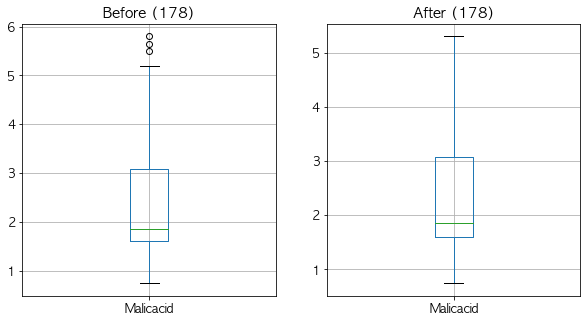

In [17]:
prep_df2 = wine[['Malicacid']].clip(down, top)

plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

fig, axes = plt.subplots(1,2)
for data, ax, title in zip([wine[['Malicacid']], prep_df2], axes, ['Before', 'After']):
    data.boxplot(ax=ax)
    ax.set_title("{} ({})".format(title, len(data)))
plt.show()

### 클리핑
- 이상치 상, 하한을 특정값으로 지정하여, 벗어나는 값을 조정
- 이상치 경계값에 대한 확실한 정보를 가지고 있거나, 데이터를 특정 경계값으로 제한하고 싶을 때

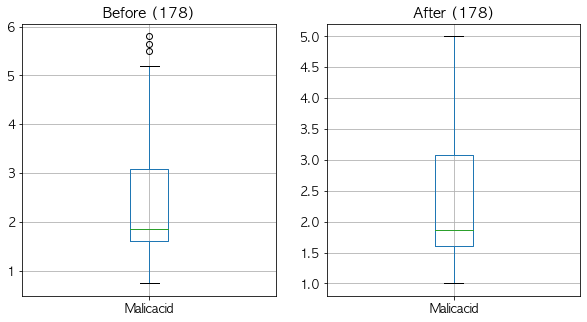

In [18]:
prep_df3 = wine[['Malicacid']].clip(1,5)

plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

fig, axes = plt.subplots(1,2)
for data, ax, title in zip([wine[['Malicacid']], prep_df3], axes, ['Before', 'After']):
    data.boxplot(ax=ax)
    ax.set_title("{} ({})".format(title, len(data)))
plt.show()

## 2-3 클래스 불균형 처리
- 오버샘플링 & 언더샘플링

In [35]:
from sklearn.datasets import load_breast_cancer
from collections import Counter

data = load_breast_cancer()
df = pd.DataFrame(np.c_[data['data'], data['target']], 
                  columns = list(data.feature_names) + ['target'])

df = df.filter(['mean radius', 'mean texture', 'mean area', 'target'])
print("3 front rows: \n", df.head(3), "\n")
print("original data class distribution:", Counter(df['target']))


df1 = df.loc[df['target']==0].sample(50)
df2 = df.loc[df['target']==1].sample(250)
imb_df = pd.concat([df1, df2]).reset_index(drop=True)
print("imbalanced data class distribution: ", Counter(imb_df['target']))

features = imb_df.drop('target', axis=1)
target = imb_df['target']

3 front rows: 
    mean radius  mean texture  mean area  target
0        17.99         10.38     1001.0     0.0
1        20.57         17.77     1326.0     0.0
2        19.69         21.25     1203.0     0.0 

original data class distribution: Counter({1.0: 357, 0.0: 212})
imbalanced data class distribution:  Counter({1.0: 250, 0.0: 50})


### 랜덤 오버샘플링
- 기존에 존재하는 소수의 클래스를 단순복제
- 분포의 편화는 없으나 소수 클래스인 데이터가 많아지면서 해당 클래스에 대한 가중치가 높아지게 된다. 한편 단순히 동일 데이터의 증가이므로 과적할 될 수도 있다

imbalanced data class distribution:  Counter({1.0: 250, 0.0: 50})
oversampled data class distribution:  Counter({0.0: 250, 1.0: 250})


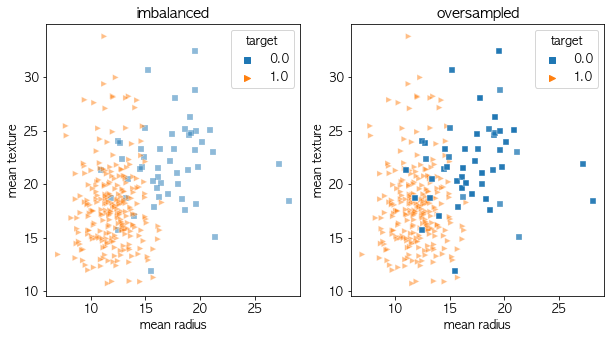

In [44]:
from imblearn.over_sampling import RandomOverSampler

os = RandomOverSampler(random_state=0)
bal_features, bal_target = os.fit_resample(features, target)
print("imbalanced data class distribution: ", Counter(target))
print("oversampled data class distribution: ", Counter(bal_target))

over_df1 = pd.DataFrame(np.c_[bal_features, bal_target], columns = imb_df.columns)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_title("imbalanced")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=imb_df,
               ax=ax[0], alpha=0.5, style='target', markers=['s', '>']);

ax[1].set_title("oversampled")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=over_df1,
               ax=ax[1], alpha=0.5, style='target', markers=['s', '>']);

plt.show()

### SMOTE (synthetic minority oversampling technique)
- 임의의 소수 클래스 데이터로부터 인근 소수 클래스 사이에 새로운 데이터 생성
    - 임의의 소수 클래스 x를 잡고 가장 가까운 k개의 이웃을 찾은 다음, k개의 이웃과 x사이에 임의의 새로운 데이터 x' 생성

imbalanced data class distribution:  Counter({1.0: 250, 0.0: 50})
oversampled data class distribution:  Counter({0.0: 250, 1.0: 250})


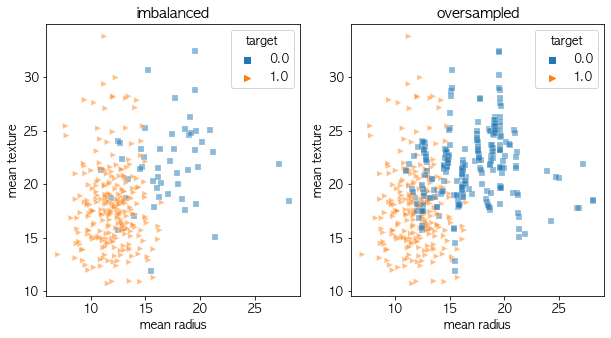

In [53]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0, k_neighbors=3)
bal_features, bal_target = os.fit_resample(features, target)
print("imbalanced data class distribution: ", Counter(target))
print("oversampled data class distribution: ", Counter(bal_target))

over_df2 = pd.DataFrame(np.c_[bal_features, bal_target], columns = imb_df.columns)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_title("imbalanced")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=imb_df,
               ax=ax[0], alpha=0.5, style='target', markers=['s', '>']);

ax[1].set_title("oversampled")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=over_df2,
               ax=ax[1], alpha=0.5, style='target', markers=['s', '>']);
plt.show()

### Borderline SMOTE
- 다수, 소수의 클래스를 구분하는 선을 그을 때 서로 인접해있는 경계선에 있는 소수 클래스의 데이터에 대해서 SMOTE
    - 임의의 소수 클래스 데이터 x와 근접하는 데이터들의 클래스를 살펴보고 여기에 소수와 다수 클래스가 모두 존재하면 이 데이터를 경계데이터롤 분류한다. 
    - 그렇지 않은 경우 소수 클래스 데이터 x는 고려하지 않는다

imbalanced data class distribution:  Counter({1.0: 250, 0.0: 50})
oversampled data class distribution:  Counter({0.0: 250, 1.0: 250})


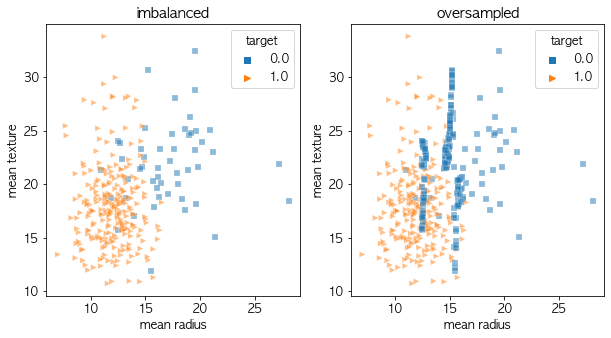

In [49]:
from imblearn.over_sampling import BorderlineSMOTE

os = BorderlineSMOTE(random_state=0, k_neighbors=3)
bal_features, bal_target = os.fit_resample(features, target)
print("imbalanced data class distribution: ", Counter(target))
print("oversampled data class distribution: ", Counter(bal_target))

over_df3 = pd.DataFrame(np.c_[bal_features, bal_target], columns = imb_df.columns)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_title("imbalanced")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=imb_df,
               ax=ax[0], alpha=0.5, style='target', markers=['s', '>']);

ax[1].set_title("oversampled")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=over_df3,
               ax=ax[1], alpha=0.5, style='target', markers=['s', '>']);
plt.show()

### K-means SMOTE

imbalanced data class distribution:  Counter({1.0: 250, 0.0: 50})
oversampled data class distribution:  Counter({0.0: 252, 1.0: 250})


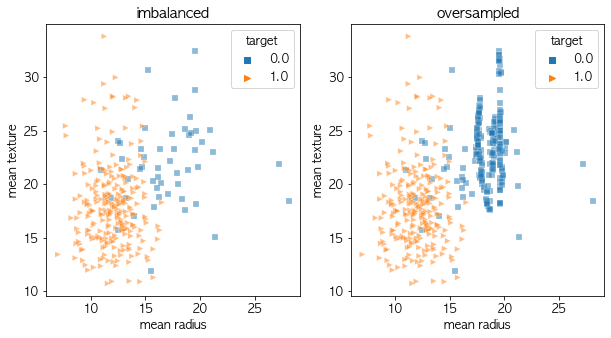

In [52]:
from imblearn.over_sampling import KMeansSMOTE

os = KMeansSMOTE(random_state=0, k_neighbors=3)
bal_features, bal_target = os.fit_resample(features, target)
print("imbalanced data class distribution: ", Counter(target))
print("oversampled data class distribution: ", Counter(bal_target))

over_df4 = pd.DataFrame(np.c_[bal_features, bal_target], columns = imb_df.columns)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_title("imbalanced")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=imb_df,
               ax=ax[0], alpha=0.5, style='target', markers=['s', '>']);

ax[1].set_title("oversampled")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=over_df4,
               ax=ax[1], alpha=0.5, style='target', markers=['s', '>']);
plt.show()

### SVM SMOTE
- 소수 클래스인 support vector 데이터들을 경계데이터로 삼고 SMOTE 적용

imbalanced data class distribution:  Counter({1.0: 250, 0.0: 50})
oversampled data class distribution:  Counter({0.0: 250, 1.0: 250})


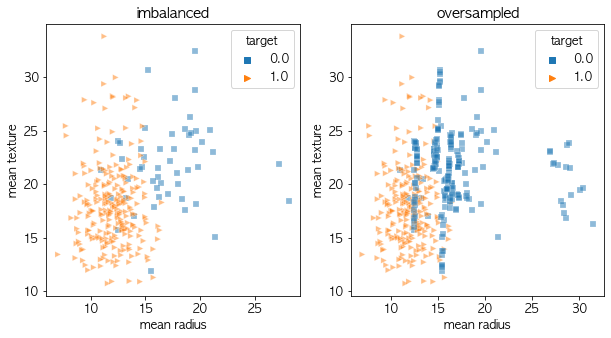

In [54]:
from imblearn.over_sampling import SVMSMOTE
os = SVMSMOTE(random_state=0, k_neighbors=3)
bal_features, bal_target = os.fit_resample(features, target)
print("imbalanced data class distribution: ", Counter(target))
print("oversampled data class distribution: ", Counter(bal_target))

over_df5 = pd.DataFrame(np.c_[bal_features, bal_target], columns = imb_df.columns)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_title("imbalanced")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=imb_df,
               ax=ax[0], alpha=0.5, style='target', markers=['s', '>']);

ax[1].set_title("oversampled")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=over_df5,
               ax=ax[1], alpha=0.5, style='target', markers=['s', '>']);
plt.show()

### ADASYN (Adaptive synthetic sampling)
- 가중치를 통한 SMOTE
    - 인접한 데이터의 소수 클래스와 다수 클래스의 비율에 따라 생성되는 샘플의 개수 정해짐
    - 생성 샘플계수 : 소수 클래스 필도에 반비례

imbalanced data class distribution:  Counter({1.0: 250, 0.0: 50})
oversampled data class distribution:  Counter({0.0: 251, 1.0: 250})


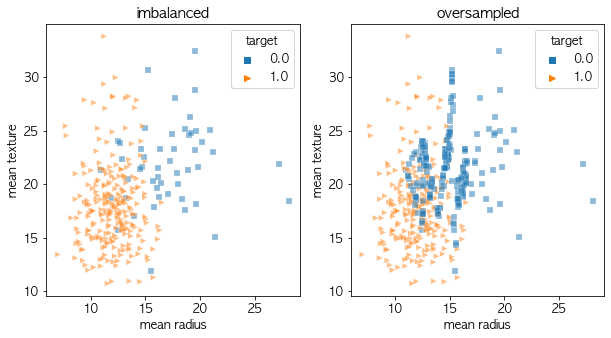

In [56]:
from imblearn.over_sampling import ADASYN
os = ADASYN(random_state=0, n_neighbors=3)
bal_features, bal_target = os.fit_resample(features, target)
print("imbalanced data class distribution: ", Counter(target))
print("oversampled data class distribution: ", Counter(bal_target))

over_df6 = pd.DataFrame(np.c_[bal_features, bal_target], columns = imb_df.columns)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_title("imbalanced")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=imb_df,
               ax=ax[0], alpha=0.5, style='target', markers=['s', '>']);

ax[1].set_title("oversampled")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=over_df6,
               ax=ax[1], alpha=0.5, style='target', markers=['s', '>']);
plt.show()

### 오버샘플링 된 데이터로 분류 학습 및 결과 비교
- 각 기법 로지스틱 회귀모델링 후 정확도 계산

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

data = [imb_df, over_df1, over_df2, over_df3, over_df4, over_df5, over_df6]
data_title = ['no oversampling', 'RandomOverSampler', 'SMOTE', 'BorderlineSMOTE', 
              'KMeansSMOTE', 'SVMSMOTE', 'ADASYN']

scores = pd.DataFrame(index=['train acc', 'test acc', 'train f1', 'test f1'], columns=data_title)

for df, title in zip(data, data_title):
    features = df.drop('target', axis=1)
    target = df['target']
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
    lr = LogisticRegression(max_iter=30)
    lr.fit(X_train, y_train)
    
    pred_train = lr.predict(X_train)
    pred_test = lr.predict(X_test)
    
    scores.loc['train acc', title] = accuracy_score(y_train, pred_train)
    scores.loc['test acc', title] = accuracy_score(y_test, pred_test)
    scores.loc['train f1', title] = f1_score(y_train, pred_train)
    scores.loc['test f1', title] = f1_score(y_test, pred_test)

scores

,no oversampling,RandomOverSampler,SMOTE,BorderlineSMOTE,KMeansSMOTE,SVMSMOTE,ADASYN
train acc,0.946667,0.834667,0.850667,0.842667,0.960106,0.869333,0.805333
test acc,0.946667,0.824,0.824,0.824,0.97619,0.864,0.793651
train f1,0.968586,0.850242,0.860697,0.85213,0.962025,0.874036,0.817955
test f1,0.969697,0.807018,0.8,0.788462,0.973913,0.828283,0.763636


## 2-4 변수변환
- 특성의 scale을 바꾸는 것, 각 특성에 개별적 수행
- 트리 기반을 제외한 모델은 변수전환이 필수적

### 2-4-1 수치형 변수변환
- 선형변환 : 표준화, 최소최대 스케일링, robust scaling, quantile scaling
- 비선형변환 : 로그벼환, box-cox, yeo-johnson
- 구간분할
- 순위 변환

In [16]:
diabetes = pd.read_csv("https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/2-4_diabetes.csv")
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [17]:
X = diabetes[['Pregnancies', 'BloodPressure', 'BMI', 'Age']]
y = diabetes['Outcome']

print(X.head())
print(y.head())

   Pregnancies  BloodPressure   BMI  Age
0            6             72  33.6   50
1            1             66  26.6   31
2            8             64  23.3   32
3            1             66  28.1   21
4            0             40  43.1   33
0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64


### 표준화
- $\frac{데이터포인트 - 데이터\ 평균}{데이터\ 표준편차}$ : 평균을 0, 분산을 1로 변경하여 모든 특성이 같은 크기를 가지게 한다.
- 표준점수 z는 원수치가 평균에서 얼마나 떨어져있나 나타내나, 최소 최대값의 크기를 제한하지는 않는다.

In [18]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss_X = ss.fit_transform(X)
ss_X = pd.DataFrame(ss_X, columns=X.columns)

print('Before')
print(X.describe().loc[['mean', 'std', 'max', 'min'],:], '\n')

print('After')
print(ss_X.describe().loc[['mean', 'std', 'max', 'min'],:], '\n')


Before
      Pregnancies  BloodPressure        BMI        Age
mean     3.845052      69.105469  31.992578  33.240885
std      3.369578      19.355807   7.884160  11.760232
max     17.000000     122.000000  67.100000  81.000000
min      0.000000       0.000000   0.000000  21.000000 

After
       Pregnancies  BloodPressure           BMI           Age
mean  2.544261e-17  -1.327244e-17  2.295979e-16  1.857600e-16
std   1.000652e+00   1.000652e+00  1.000652e+00  1.000652e+00
max   3.906578e+00   2.734528e+00  4.455807e+00  4.063716e+00
min  -1.141852e+00  -3.572597e+00 -4.060474e+00 -1.041549e+00 



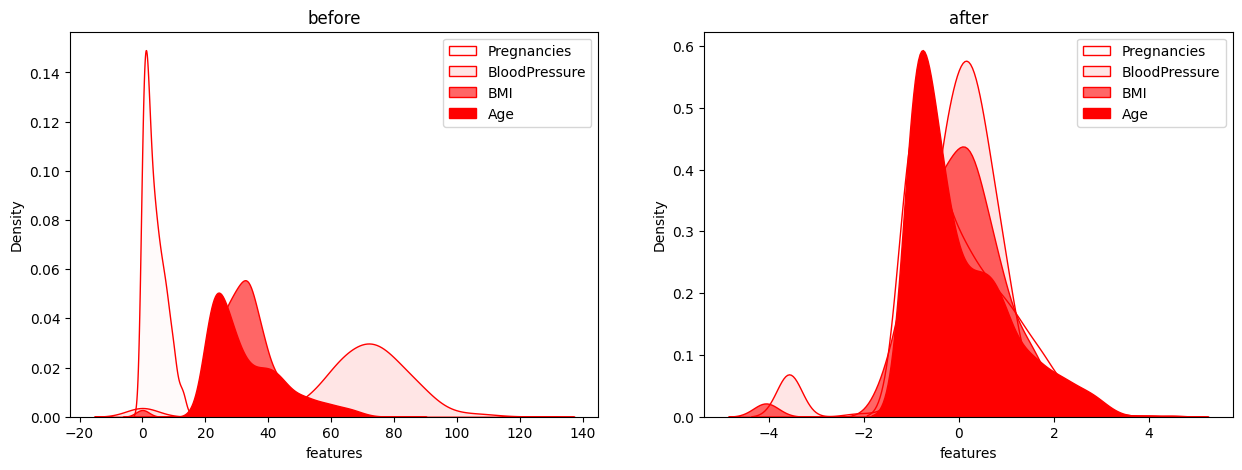

In [19]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
for col, a in zip(X.columns, [0.02, 0.1, 0.6, 1]):
    sns.kdeplot(X[col], alpha=a, legend=True, ax=ax[0], shade=True, color='r')
ax[0].legend(X.columns)
ax[0].set_xlabel('features')
ax[0].set_title('before')

for col, a in zip(ss_X.columns, [0.02, 0.1, 0.6, 1]):
    sns.kdeplot(ss_X[col], alpha=a, legend=True, ax=ax[1], shade=True, color='r')
ax[1].legend(ss_X.columns)
ax[1].set_xlabel('features')
ax[1].set_title('after')

plt.show()

### 최소최대 스케일링
- 모든 특성이 정확하게 0-1 : $\frac{데이터값 - 최솟값}{최댓값-최솟값}$
- 처음부터 범위가 정해진 변수는 최소최대 스케일링이 자연스러움
- 변환 후에 평균이 정확이 0이 되지 않고, 이상치의 영향력이 커, 표준화 방법이 더 자주 쓰인다

In [24]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
mm_X = mm.fit_transform(X)
mm_X = pd.DataFrame(mm_X, columns=X.columns)

print('Before')
print(X.describe().loc[['mean', 'std', 'max', 'min'],:], '\n')

print('After')
print(mm_X.describe().loc[['mean', 'std', 'max', 'min'],:], '\n')


Before
      Pregnancies  BloodPressure        BMI        Age
mean     3.845052      69.105469  31.992578  33.240885
std      3.369578      19.355807   7.884160  11.760232
max     17.000000     122.000000  67.100000  81.000000
min      0.000000       0.000000   0.000000  21.000000 

After
      Pregnancies  BloodPressure       BMI       Age
mean      0.22618       0.566438  0.476790  0.204015
std       0.19821       0.158654  0.117499  0.196004
max       1.00000       1.000000  1.000000  1.000000
min       0.00000       0.000000  0.000000  0.000000 



In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
for col, a in zip(X.columns, [0.02, 0.1, 0.6, 1]):
    sns.kdeplot(X[col], alpha=a, legend=True, ax=ax[0], shade=True, color='r')
ax[0].legend(X.columns)
ax[0].set_xlabel('features')
ax[0].set_title('before')

for col, a in zip(mm_X.columns, [0.02, 0.1, 0.6, 1]):
    sns.kdeplot(mm_X[col], alpha=a, legend=True, ax=ax[1], shade=True, color='r')
ax[1].legend(mm_X.columns)
ax[1].set_xlabel('features')
ax[1].set_title('after')

plt.show()

### Robust scaling
- 특성이 같은 스케일이라 표준화 스케일링과 비슷하나, 평균과 분산 대신 중앙값과 사분위수를 사용한다. 
- 이상치의 영향력이 없음 $\frac{데이터 - 중앙값}{3사분위수-1사분위수}$

In [27]:
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
rs_X = rs.fit_transform(X)
rs_X = pd.DataFrame(rs_X, columns=X.columns)

print('Before')
print(X.describe().loc[['mean', 'std', 'max', 'min'],:], '\n')

print('After')
print(rs_X.describe().loc[['mean', 'std', 'max', 'min'],:], '\n')


Before
      Pregnancies  BloodPressure        BMI        Age
mean     3.845052      69.105469  31.992578  33.240885
std      3.369578      19.355807   7.884160  11.760232
max     17.000000     122.000000  67.100000  81.000000
min      0.000000       0.000000   0.000000  21.000000 

After
      Pregnancies  BloodPressure       BMI       Age
mean     0.169010      -0.160807 -0.000798  0.249464
std      0.673916       1.075323  0.847759  0.691778
max      2.800000       2.777778  3.774194  3.058824
min     -0.600000      -4.000000 -3.440860 -0.470588 



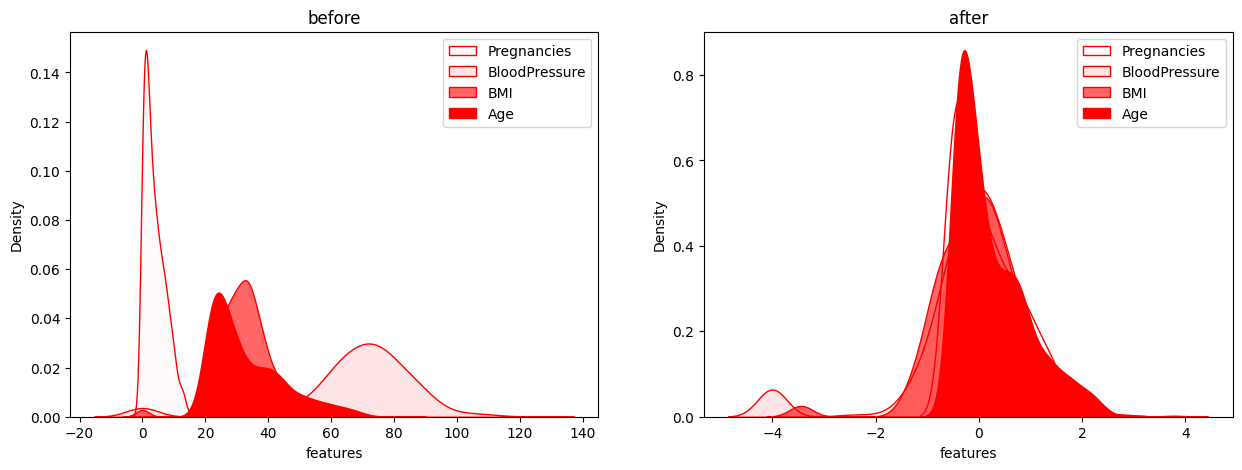

In [28]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
for col, a in zip(X.columns, [0.02, 0.1, 0.6, 1]):
    sns.kdeplot(X[col], alpha=a, legend=True, ax=ax[0], shade=True, color='r')
ax[0].legend(X.columns)
ax[0].set_xlabel('features')
ax[0].set_title('before')

for col, a in zip(ss_X.columns, [0.02, 0.1, 0.6, 1]):
    sns.kdeplot(rs_X[col], alpha=a, legend=True, ax=ax[1], shade=True, color='r')
ax[1].legend(rs_X.columns)
ax[1].set_xlabel('features')
ax[1].set_title('after')

plt.show()

### Quantile Scaling
- 균등분포, 정규분포에 가깝게 데이터 변환
- 데이터의 1000개의 분위를 사용하여 분포를 재배치 : 이상치에 민감하지 않으며 전체 데이터를 0~1사이로 압축
    - 기본값보다 작은 크기의 데이터가 입력될 경우, 데이터의 개수대로 n_quantiles값 설정
    - Rank Gauss 방법으로서 수치형 변수를 순위로 변환한 뒤 순서를 유지한 채 정규분포가 되도록
    - 전체 데이터를 -5 ~ 5사이로 압축

In [36]:
from sklearn.preprocessing import QuantileTransformer
qtu = QuantileTransformer(output_distribution='uniform', n_quantiles=len(X))
qtu_X = qtu.fit_transform(X)
qtu_X = pd.DataFrame(qtu_X, columns=X.columns)

print('Before')
print(X.describe().loc[['mean', 'std', 'max', 'min'],:], '\n')

print('After')
print(qtu_X.describe().loc[['mean', 'std', 'max', 'min'],:], '\n')


Before
      Pregnancies  BloodPressure        BMI        Age
mean     3.845052      69.105469  31.992578  33.240885
std      3.369578      19.355807   7.884160  11.760232
max     17.000000     122.000000  67.100000  81.000000
min      0.000000       0.000000   0.000000  21.000000 

After
      Pregnancies  BloodPressure       BMI       Age
mean     0.489773       0.499110  0.499972  0.496769
std      0.303331       0.290718  0.289391  0.294365
max      1.000000       1.000000  1.000000  1.000000
min      0.000000       0.000000  0.000000  0.000000 



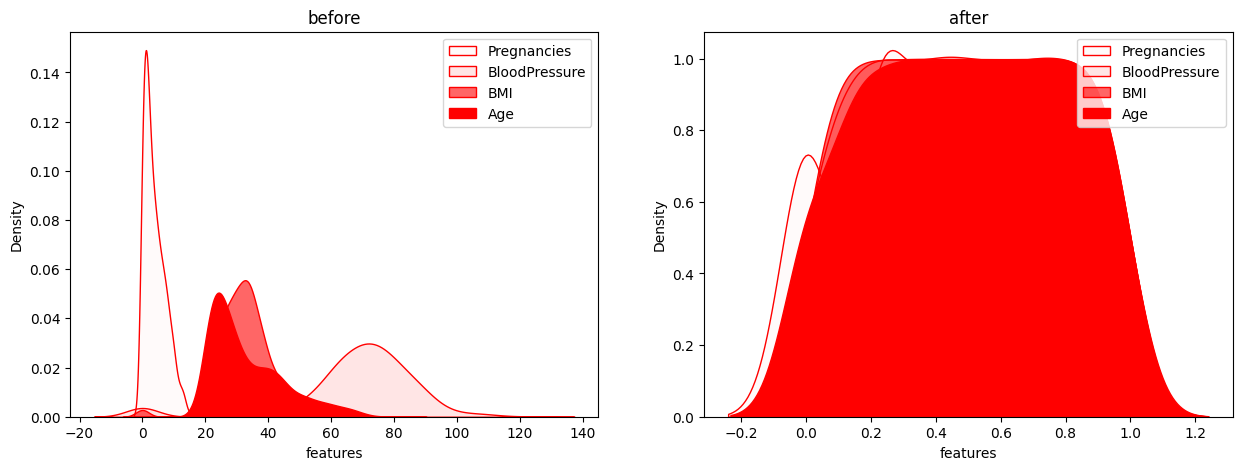

In [37]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
for col, a in zip(X.columns, [0.02, 0.1, 0.6, 1]):
    sns.kdeplot(X[col], alpha=a, legend=True, ax=ax[0], shade=True, color='r')
ax[0].legend(X.columns)
ax[0].set_xlabel('features')
ax[0].set_title('before')

for col, a in zip(ss_X.columns, [0.02, 0.1, 0.6, 1]):
    sns.kdeplot(qtu_X[col], alpha=a, legend=True, ax=ax[1], shade=True, color='r')
ax[1].legend(qtu_X.columns)
ax[1].set_xlabel('features')
ax[1].set_title('after')

plt.show()

In [38]:
from sklearn.preprocessing import QuantileTransformer
qtn = QuantileTransformer(output_distribution='normal', n_quantiles=len(X))
qtn_X = qtn.fit_transform(X)
qtn_X = pd.DataFrame(qtn_X, columns=X.columns)

print('Before')
print(X.describe().loc[['mean', 'std', 'max', 'min'],:], '\n')

print('After')
print(qtn_X.describe().loc[['mean', 'std', 'max', 'min'],:], '\n')


Before
      Pregnancies  BloodPressure        BMI        Age
mean     3.845052      69.105469  31.992578  33.240885
std      3.369578      19.355807   7.884160  11.760232
max     17.000000     122.000000  67.100000  81.000000
min      0.000000       0.000000   0.000000  21.000000 

After
      Pregnancies  BloodPressure       BMI       Age
mean    -0.518602      -0.137647 -0.034803 -0.270105
std      2.066619       1.426041  1.150110  1.696606
max      5.199338       5.199338  5.199338  5.199338
min     -5.199338      -5.199338 -5.199338 -5.199338 



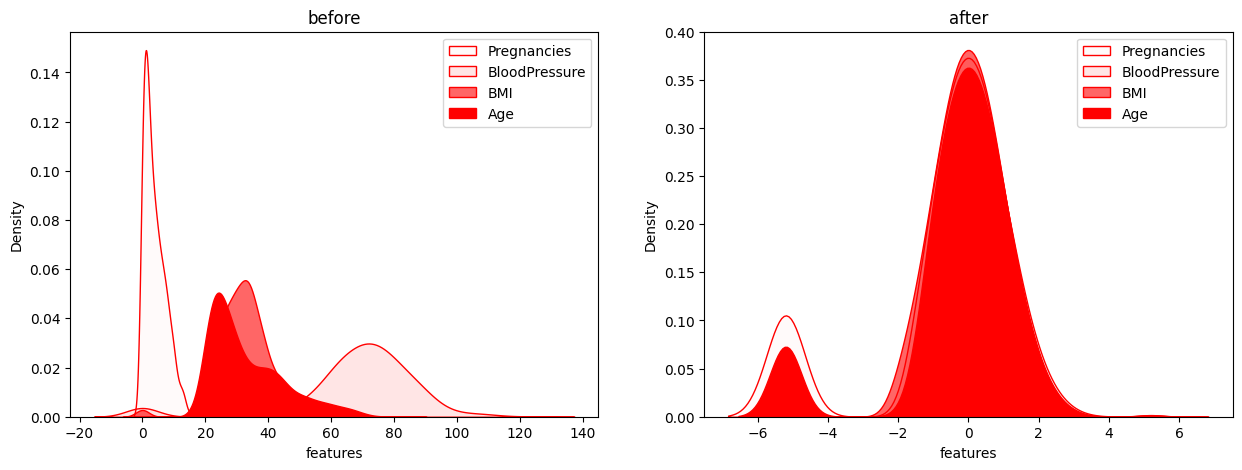

In [39]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
for col, a in zip(X.columns, [0.02, 0.1, 0.6, 1]):
    sns.kdeplot(X[col], alpha=a, legend=True, ax=ax[0], shade=True, color='r')
ax[0].legend(X.columns)
ax[0].set_xlabel('features')
ax[0].set_title('before')

for col, a in zip(ss_X.columns, [0.02, 0.1, 0.6, 1]):
    sns.kdeplot(qtn_X[col], alpha=a, legend=True, ax=ax[1], shade=True, color='r')
ax[1].legend(qtn_X.columns)
ax[1].set_xlabel('features')
ax[1].set_title('after')

plt.show()

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

data = [X, ss_X, mm_X, rs_X, qtu_X, qtn_X]
y = diabetes['Outcome']
data_title=['no scaling', 'Standard', 'MinMax', 'Robust', 'QuantileUniform' ,'QuantileNormal']
scores = pd.DataFrame(index=['Train acc', 'Test acc', 'Train F1', 'Test F1'], columns=data_title)
coeffs = pd.DataFrame(index=data_title, columns=X.columns)

for df, title in zip(data, data_title):
    X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=0)
    lr = LogisticRegression(max_iter=300)
    lr.fit(X_train, y_train)
    
    pred_train = lr.predict(X_train)
    pred_test = lr.predict(X_test)
    
    scores.loc['Train acc', title] = accuracy_score(y_train, pred_train)
    scores.loc['Test acc', title] = accuracy_score(y_test, pred_test)
    scores.loc['Train F1', title] = f1_score(y_train, pred_train)
    scores.loc['Test F1', title] = f1_score(y_test, pred_test)
    coeffs.loc[title, :] = lr.coef_
    
scores    

,no scaling,Standard,MinMax,Robust,QuantileUniform,QuantileNormal
Train acc,0.6875,0.689236,0.682292,0.689236,0.701389,0.680556
Test acc,0.692708,0.692708,0.682292,0.692708,0.692708,0.697917
Train F1,0.470588,0.471976,0.403909,0.471976,0.50289,0.468208
Test F1,0.40404,0.40404,0.26506,0.40404,0.427184,0.395833


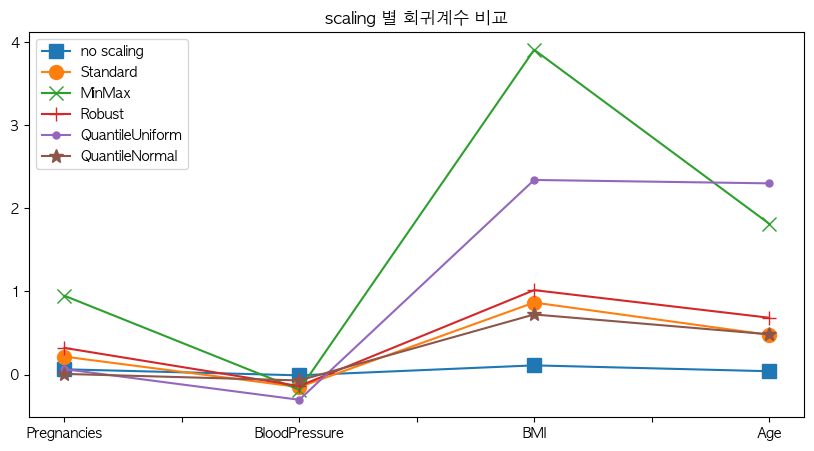

In [84]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.set_title("scaling 별 회귀계수 비교")
for i, marker in enumerate(['s', 'o', 'x', '+', '.', '*']):
    coeffs.T.iloc[:,i].plot(ax=ax, marker=marker, ms=10)
ax.legend()
plt.show()

### 로그변환
- 큰 수의 범위를 압축하고, 작은 수의 범위르 확장

In [97]:
realestate = pd.read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/2-4_BHP.csv').dropna().reset_index(drop=True) # 결측치 삭제 후, 인덱스 리셋
X = realestate[['bath', 'balcony']] # 수치형 변수 두개만 사용
y = realestate[['price']]
realestate.head(3)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00


In [98]:
example_y = 39.07
print(f"원본 데이터: {example_y:.3f}")

# 상용로그
y_log = np.log10(example_y)
y_log_inv = 10**(y_log)
print(f"상용로그: {y_log:.3f} <---> {y_log_inv:.3f}")

# 자연로그
y_log2 = np.log(example_y) 
y_log2_inv = np.exp(y_log2) # 변환 전 값으로 되돌리기
print(f"자연로그: {y_log2:.3f} <--> {y_log2_inv:.3f}")

# 데이터에 1을 더한(plus) 후 자연로그
y_log3 = np.log1p(example_y) 
y_log3_inv = np.expm1(y_log3) # 변환 전 값으로 되돌리기
print(f"자연로그1p: {y_log3:.3f} <--> {y_log3_inv:.3f}")

# 데이터의 절대값에 자연로그 변환을 한 후, 데이터의 원래 부호 붙임
y_log4 = np.sign(example_y)*np.log(np.abs(example_y))
y_log4_inv = np.sign(y_log4)*np.exp(np.abs(y_log4))
print(f"절대값+자연로그+부호: {y_log4:.3f} <--> {y_log4_inv:.3f}")

원본 데이터: 39.070
상용로그: 1.592 <---> 39.070
자연로그: 3.665 <--> 39.070
자연로그1p: 3.691 <--> 39.070
절대값+자연로그+부호: 3.665 <--> 39.070


### 거듭제곱 변환
- Box-cox : 데이터를 정규 분포에 가깝게 만들거나, 데이터 분산 안정화, 양수 데이터에만 적용 가능
- Yeo-Johnson : 데이터 분산 안정화, 음수를 포함하는 실수 전체 적용 가능

In [99]:
from sklearn.preprocessing import PowerTransformer

PTB = PowerTransformer(method='box-cox')
PTY = PowerTransformer(method='yeo-johnson')
y_ptb = pd.DataFrame(PTB.fit_transform(np.reshape([y], (-1,1))))
y_pty = pd.DataFrame(PTY.fit_transform(np.reshape([y], (-1,1))))
y_ptb_inv = pd.DataFrame(PTB.inverse_transform(y_ptb))

print("raw: ", y.head(1).values)
print("box-cox: ", y_ptb.head(1).values)
print("box-cox inv: ", y_ptb_inv.head(1).values)

raw:  [[39.07]]
box-cox:  [[-1.06667465]]
box-cox inv:  [[39.07]]


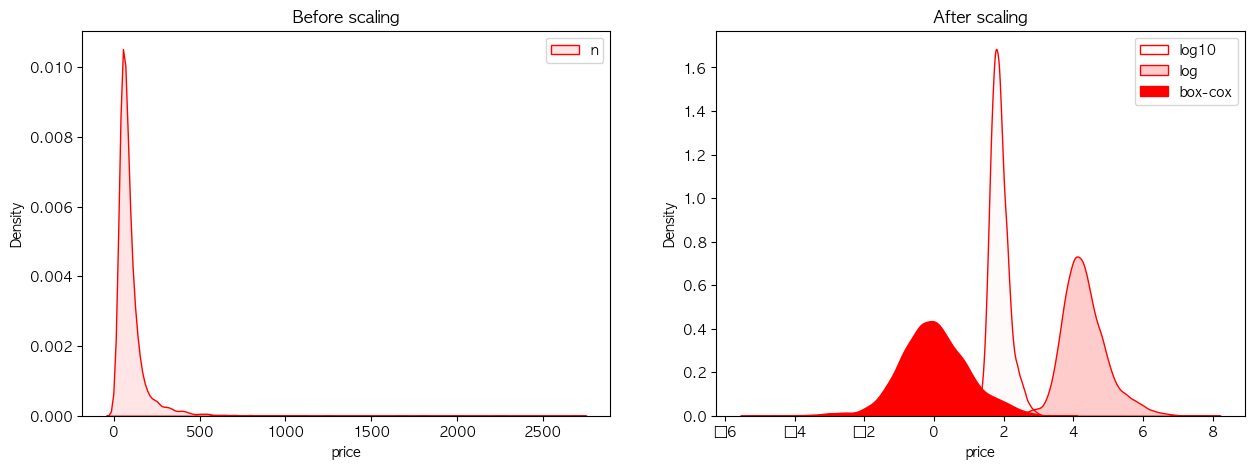

In [112]:
noscaling, log10, log, boxcox = y, np.log10(y), np.log(y), y_ptb
boxcox = boxcox.rename(columns={0:'price'})
data = [noscaling, log10, log, boxcox]
data_title=['no scaling', 'log10', 'log', 'box-cox']
alphas = [0.1, 0.02, 0.2, 1]
fig, ax = plt.subplots(1, 2, figsize=(15,5))
for i, df, a in zip(range(len(data)), data, alphas):
    if i==0:
        sns.kdeplot(df['price'], ax=ax[0], alpha=a, shade=True, color='red')
        ax[0].legend(data_title[0])
        ax[0].set_title('Before scaling')
    else:
        sns.kdeplot(df['price'], ax=ax[1], alpha=a, shade=True, color='red')
        ax[1].legend(data_title[1:])
        ax[1].set_title('After scaling')
plt.show()

In [114]:
noscaling, log10, log, log1p, sblog, bc, yj = y, np.log10(y), np.log(y), np.log1p(y), np.sign(y)*np.log(np.abs(y)), y_ptb, y_pty
data = [noscaling, log10, log, log1p, sblog, bc, yj]
data_title = ['no scaling', 'log10', 'log', 'log1p', 'sign+abs+log', 'box-cox', 'yeo-johnson']

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

scores = pd.DataFrame(index=['Train r2', 'Test r2'], columns=data_title)
for df, title in zip(data, data_title):
    X_train, X_test, y_train, y_test = train_test_split(X, df, random_state=0)
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    scores.loc['Train r2', title] = lr.score(X_train, y_train)
    scores.loc['Test r2', title] = lr.score(X_test, y_test)

scores

,no scaling,log10,log,log1p,sign+abs+log,box-cox,yeo-johnson
Train r2,0.354048,0.548043,0.548043,0.548732,0.548043,0.521241,0.521324
Test r2,0.352965,0.547998,0.547998,0.548598,0.547998,0.524295,0.524158


### 순위로 변환
- 데이터를 순위로 변환한 후 순위를 전체 데이터의 개수로 나누면 모든 데이터 값이 0~1범위에 들어감
  - 수치의 크기나 간격 정보는 소실

In [116]:
rank_X = X.rank(ascending=False)

print("before data distribution")
display(X.describe().loc[['mean', 'std', 'max', 'min'], :], )
print("after data distribution")
display(rank_X.describe().loc[['mean', 'std', 'max', 'min'], :], )

before data distribution


,bath,balcony
mean,2.458378,1.629936
std,0.881128,0.780127
max,9.000000,3.000000
min,1.000000,0.000000


after data distribution


,bath,balcony
mean,3748.500000,3748.50000
std,1926.118911,2010.62683
max,7282.500000,7295.50000
min,2.000000,503.00000


### 구간 분할
- 수치형 변수를 구간 별로 나누어 범주형 변수로 변환하는 방법
    - 순서가 있는 범주형 변수 : 순서를 수치화하여 사용
    - 범주형 변수로서 원핫 인코딩 적용 가능
- cut : bin수를 지정하거나 bin의 범위 지정
- KBinsDiscretizer : n_bins에 구간 수를 지정하여, 각 구간을 하나의 특성으로 삼는 원핫 인코딩 적용

In [117]:
binned = pd.cut(X['bath'], bins=4)
freq_df = pd.DataFrame(binned.value_counts()).reset_index().rename(columns={'index':'계급', 'bath':'빈도'}).sort_values(by='계급', ascending=True)
print('bin수 지정: \n', freq_df, '\n')

bin_edges = [0, 2, 4, 6, float('inf')]
binned2 = pd.cut(X['bath'], bin_edges, right=False)
freq_df2 = pd.DataFrame(binned2.value_counts()).reset_index().rename(columns={'index':'계급', 'bath':'빈도'}).sort_values(by='계급', ascending=True)
print('bin범위 지정: \n', freq_df2, '\n')                                                                                      

bin수 지정: 
              계급    빈도
0  (0.992, 3.0]  6774
1    (3.0, 5.0]   642
2    (5.0, 7.0]    77
3    (7.0, 9.0]     3 

bin범위 지정: 
            계급    빈도
2  [0.0, 2.0)   428
0  [2.0, 4.0)  6346
1  [4.0, 6.0)   642
3  [6.0, inf)    80 



In [119]:
from sklearn.preprocessing import KBinsDiscretizer

kb = KBinsDiscretizer(n_bins=3, strategy='quantile')
kb.fit(np.array(X['bath']).reshape(-1,1))
print("bin edges: ", kb.bin_edges_[0], '\n')

kbbin = kb.bin_edges_[0]
bin_edges = []
for i in range(len(kbbin)):
    if len(kbbin)-1 != i:
        tup = (int(kbbin[i]), int(kbbin[i+1]))
        bin_edges.append(tup)
kbinned = kb.transform(np.array(X['bath']).reshape(-1,1))        
result = pd.DataFrame(kbinned.toarray(), columns=bin_edges)
print(result.head(3))

bin edges:  [1. 2. 3. 9.] 

   (1, 2)  (2, 3)  (3, 9)
0     0.0     1.0     0.0
1     0.0     0.0     1.0
2     0.0     0.0     1.0


### 2-4-2 범주형 변수 변환
- 원핫인코딩, 더미코딩, 숫자로 표현된 범주형 특성 변환, 레이블 인코딩, 특징 해싱, 빈도 인코딩

In [131]:
estate = pd.read_csv("https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/2-4_BHP.csv").dropna().reset_index(drop=True)
print(estate.info(), '\n')

print("범주형 변수 기술 통계:")
print(estate.describe(include='object'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7496 entries, 0 to 7495
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     7496 non-null   object 
 1   availability  7496 non-null   object 
 2   location      7496 non-null   object 
 3   size          7496 non-null   object 
 4   society       7496 non-null   object 
 5   total_sqft    7496 non-null   object 
 6   bath          7496 non-null   float64
 7   balcony       7496 non-null   float64
 8   price         7496 non-null   float64
dtypes: float64(3), object(6)
memory usage: 527.2+ KB
None 

범주형 변수 기술 통계:
                   area_type   availability    location   size  society  \
count                   7496           7496        7496   7496     7496   
unique                     4             74         634     15     2592   
top     Super built-up  Area  Ready To Move  Whitefield  2 BHK  GrrvaGr   
freq                    6017           5709   

### 원핫 인코딩
- 범주형 변수의 모든 수준을 각각 새로운 특성으로 삼아서 0,1을 가지도록 데이터 변환
    - 더미코딩과 유사하지만, 더미코딩은 모든 수준 중에서 한 가지 수준은 제외하고 나머지 수준들로 새로운 특성을 삼음

In [132]:
print("범주형 변수의 수준 갯수: ", estate[['area_type']].nunique())
print(estate[['area_type']].head(5), '\n')

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
result = pd.DataFrame(ohe.fit_transform(estate[['area_type']]).toarray(), columns=ohe.get_feature_names())
print("원핫 인코딩 결과 feature 갯수: ", result.shape[1])
print(result.head())

범주형 변수의 수준 갯수:  area_type    4
dtype: int64
              area_type
0  Super built-up  Area
1            Plot  Area
2  Super built-up  Area
3  Super built-up  Area
4            Plot  Area 

원핫 인코딩 결과 feature 갯수:  4
   x0_Built-up  Area  x0_Carpet  Area  x0_Plot  Area  x0_Super built-up  Area
0                0.0              0.0            0.0                      1.0
1                0.0              0.0            1.0                      0.0
2                0.0              0.0            0.0                      1.0
3                0.0              0.0            0.0                      1.0
4                0.0              0.0            1.0                      0.0


### 더미코딩
- 범주형 변수의 수준이 n개 일때 가변수를 n개 만들어버리면 다중공선성이 생기므로 이를 방지하기 위해 n-1개의 가변수를 만드는 것
    - pd.get_dummies(drop_first=True)
    - 범주형 변수의 수준 개수가 너무 많을 경우 정보가 적은 특징의 대량 생산가능 => 다른 인코딩 혹은 수준 갯수 줄이는 방법 생각

In [133]:
result2 = pd.get_dummies(estate['area_type'], drop_first=True)

print("범주형 변수의 수준 갯수: ", estate[['area_type']].nunique())
print(estate[['area_type']].head(5), '\n')

print("더미코딩 후 결과 feature 개수: ", result2.shape[1])
print(result2.head())

범주형 변수의 수준 갯수:  area_type    4
dtype: int64
              area_type
0  Super built-up  Area
1            Plot  Area
2  Super built-up  Area
3  Super built-up  Area
4            Plot  Area 

더미코딩 후 결과 feature 개수:  3
   Carpet  Area  Plot  Area  Super built-up  Area
0             0           0                     1
1             0           1                     0
2             0           0                     1
3             0           0                     1
4             0           1                     0


### 숫자로 표현된 범주형 특성 변환
- 명목척도인 변수임에도 불구하고 데이터 작성규칙에 따라 단순히 숫자로 입력되어 있는 경우라면, 연속형 변수로 다루면 안된다. 이를 위해 해당 타입을 범주형으로 변경하는 방법 사용

In [134]:
estate['area_type'] = estate['area_type'].map({'Super built-up  Area':0, 'Plot  Area':1, 'Built-up  Area':2, 'Carpet  Area':3})
print(estate['area_type'].describe(include='all'))
# area_type이 0,1,2,3라면, 서열의 의미가 없는데 수치형 변수로 인식 된다.

estate['area_type'] = estate['area_type'].astype('category')
print("기술 통계: \n", estate['area_type'].describe(include='all'))

count    7496.000000
mean        0.365662
std         0.763294
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: area_type, dtype: float64
기술 통계: 
 count     7496
unique       4
top          0
freq      6017
Name: area_type, dtype: int64


### 레이블 인코딩
- 판다스 시리즈 + replace, map / LabelEncoder
    - 사이킷런 : 범주명을 오름차순으로 정렬하여 자동으로 수치를 매기므로, 서열의 대응 여부를 classes_로 확인 필요
- 서열척도 : 순서의 정보를 가지는 수치형 레이블 그대로 사용
- 명목척도 : 레이블 수치는 의미가 없으므로 원핫인코딩이나 더미 코딩


In [135]:
print(sorted(estate['size'].unique()), '\n')
print(estate['size'].head(3))

['1 BHK', '1 RK', '11 BHK', '2 BHK', '2 Bedroom', '3 BHK', '3 Bedroom', '4 BHK', '4 Bedroom', '5 BHK', '5 Bedroom', '6 BHK', '6 Bedroom', '7 BHK', '9 BHK'] 

0        2 BHK
1    4 Bedroom
2        3 BHK
Name: size, dtype: object


In [137]:
case1 = estate['size'].replace({'1 RK':0, '1 BHK':1, '2 Bedroom':2, '2 BHK':3, '3 Bedroom':4,
                               '3 BHK':5, '4 Bedroom':6, '4 BHK':7, '5 Bedroom':8, '5 BHK':9,
                               '6 Bedroom':10, '6 BHK':11, '7 BHK':12, '9 BHK':13, '11 BHK':14})
print(case1.values[:5])

[3 6 5 3 6]


In [138]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
case2 = le.fit_transform(estate['size'])
print(case2[:5])
print(le.classes_)
# 위에 직접 지정한 것과 다름

[3 8 5 3 8]
['1 BHK' '1 RK' '11 BHK' '2 BHK' '2 Bedroom' '3 BHK' '3 Bedroom' '4 BHK'
 '4 Bedroom' '5 BHK' '5 Bedroom' '6 BHK' '6 Bedroom' '7 BHK' '9 BHK']


### 특징 해싱
- 늘어날 특징의 개수를 한정하면서 변수 변환을 하는 방법
- 변환 후의 특징의 개수르 사전에 정하고, 해시함수를 이용하여 수준별로 1로 표시할 위치를 결정
    - 원핫 인코딩은 수준마다 다른 위치에 1 표시
    - 특징해싱 : 해시함수에 따른 계산에 의해 다른 수준에서도 같은 위치에 1 표시 가능 => 희소행렬 반환
- 모델학습비용을 줄이고, 희귀범주 처리를 쉽게 하나, 선형 또는 커널모델에만 적합하고 해시된 특징은 해석 불가    

In [143]:
from sklearn.feature_extraction import FeatureHasher

fh = FeatureHasher(n_features=5, input_type='string')
hash_df = fh.transform(estate['size'].values)
hash_df = pd.DataFrame(hash_df.todense(), columns=[f"feature_{i}" for i in range(hash_df.shape[1])])
print(hash_df.value_counts(), '\n')
print(estate['size'].value_counts())

feature_0  feature_1  feature_2  feature_3  feature_4
-1.0       1.0         0.0       0.0        1.0          3412
 0.0       0.0         0.0       0.0        1.0          3024
-1.0       0.0        -1.0       0.0        1.0           700
 1.0       1.0        -1.0       2.0        2.0           193
 2.0       1.0         0.0       2.0        2.0           139
 1.0       2.0         0.0       2.0        2.0            16
-1.0       0.0         0.0       0.0        1.0            10
                      -2.0       0.0        1.0             1
                       0.0       1.0        1.0             1
dtype: int64 

2 BHK        3411
3 BHK        3012
1 BHK         353
4 BHK         347
4 Bedroom     193
3 Bedroom     120
5 Bedroom      16
2 Bedroom      16
1 RK           10
5 BHK           9
6 BHK           3
6 Bedroom       3
11 BHK          1
9 BHK           1
7 BHK           1
Name: size, dtype: int64


### 빈도 인코딩
- 각 수준의 빈도로 범주형 변수르 대체하는 방법
    - 수준의 출현빈도와 타겟변수 간의 관련성이 있을 때 유효
- 동일한 값이 발생할 수 있으며, 학습과 검증용 데이터에 대해 동일한 기준으로 빈도인코딩 필요

In [144]:
fe = estate[['availability', 'society', 'total_sqft']]
for col in ['availability', 'society', 'total_sqft']:
    freq = fe[col].value_counts()
    fe[col] = fe[col].map(freq)
fe.head(3)

,availability,society,total_sqft
0,157,5,11
1,5709,11,10
2,5709,22,4


In [145]:
estate[['availability', 'society', 'total_sqft']].head(3)

,availability,society,total_sqft
0,19-Dec,Coomee,1056
1,Ready To Move,Theanmp,2600
2,Ready To Move,Soiewre,1521


In [146]:
estate['availability'].value_counts()

Ready To Move    5709
18-Dec            180
18-May            171
19-Dec            157
18-Apr            148
                 ... 
20-Feb              1
15-Jun              1
20-Mar              1
16-Mar              1
14-Jul              1
Name: availability, Length: 74, dtype: int64